In [5]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "/Users/sebastianjaszczur/PycharmProjects/deepsat/attention_cmp/1552640099"
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from /Users/sebastianjaszczur/PycharmProjects/deepsat/attention_cmp/1552640099/variables/variables


In [6]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [7]:
import sys 
sys.path.insert(0,'../..')

In [9]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL, JeroslowWangDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [10]:
LIMIT_RUNS = 1000

In [14]:
JeroslowWangDPLL().run(CNF([[-1, -2], [+1, -2], [+1, +2]]))

[-2, 1]

In [3]:
import math
from collections import defaultdict

def jw(clauses):
    score = defaultdict(int)

    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))

    return max(score, key=score.get)

In [4]:
jw([[-1, -2], [+1, -2]])

-2

In [8]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [9]:
np.set_printoptions(precision=3, suppress=True)

In [10]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [11]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

class JeroslawDPLL(DPLL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)

In [12]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)
NormalizedJeroslawDPLL = make_normalized(JeroslawDPLL)

In [13]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [35]:
def compute_and_print_steps(sats, dpll_cls):
    print("")
    print("Results of {}".format(dpll_cls.__name__))
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    """
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()
    """

In [33]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    # compute_and_print_steps(sats, SimplifiedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    
    # compute_and_print_steps(sats, SimplifiedMostCommonDPLL)
    # compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    
    
    compute_and_print_steps(sats, NormalizedJeroslawDPLL)
    logfile.flush()

In [39]:
print_all(10, 200, 50)

KeyboardInterrupt: 

In [32]:
print_all(30, 200, 20)

We have generated 30 formulas
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 13.13; stdev step: 10.44; avg error: 0.27; stdev error: 0.51
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 21.00; stdev step: 14.96; avg error: 1.53; stdev error: 0.96


KeyboardInterrupt: 

We have generated 10 formulas
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.00; stdev step: 7.38; avg error: 0.20; stdev error: 0.40


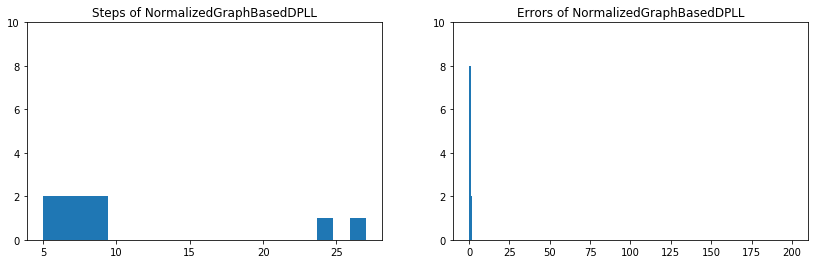

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 19.10; stdev step: 8.88; avg error: 1.60; stdev error: 0.92


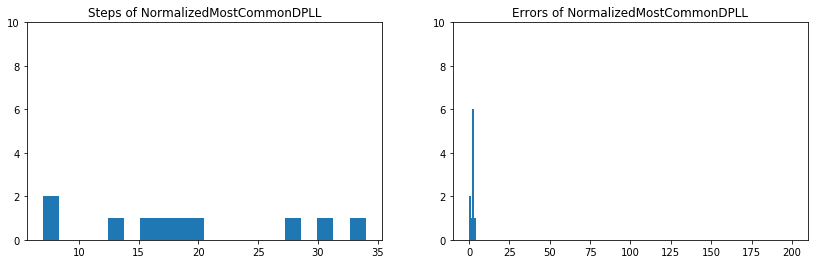

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 17.80; stdev step: 10.84; avg error: 0.90; stdev error: 0.70


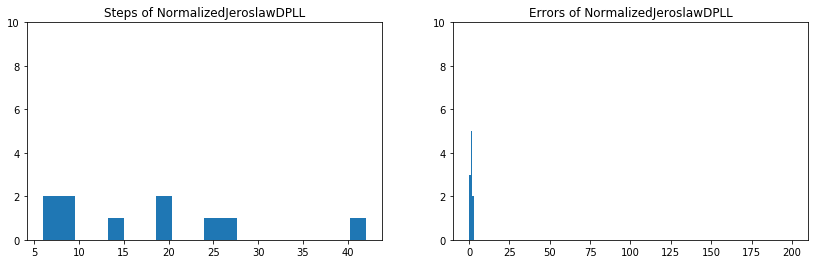

In [17]:
print_all(10, 200, 20)

We have generated 100 formulas
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.77; stdev step: 2.64; avg error: 0.04; stdev error: 0.20


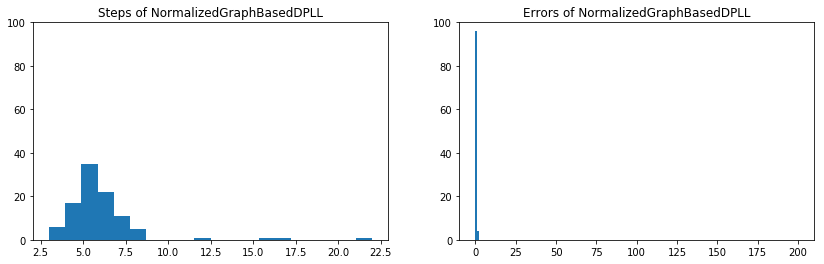

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.16; stdev step: 4.03; avg error: 0.83; stdev error: 0.71


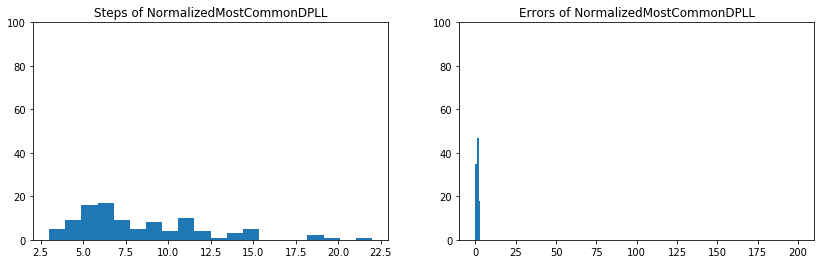

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.31; stdev step: 3.60; avg error: 0.49; stdev error: 0.56


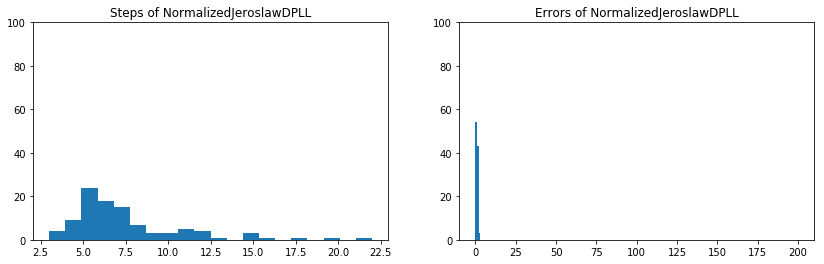

In [18]:
print_all(100, 200, 10)

We have generated 100 formulas
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 6.58; stdev step: 3.71; avg error: 0.04; stdev error: 0.20


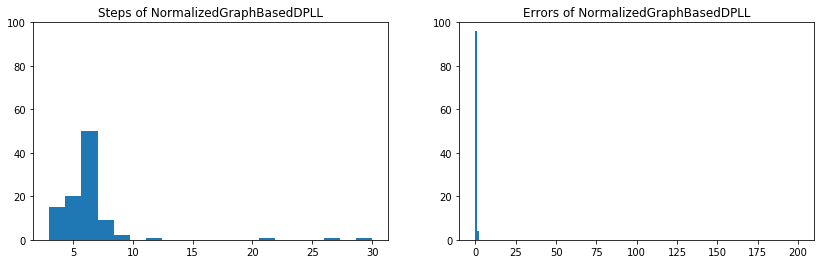

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.27; stdev step: 5.75; avg error: 1.09; stdev error: 0.87


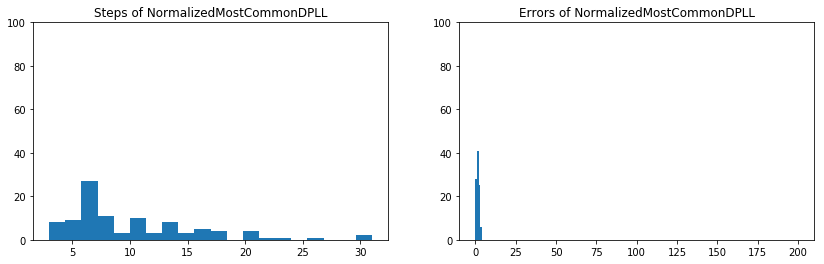

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.86; stdev step: 4.90; avg error: 0.65; stdev error: 0.68


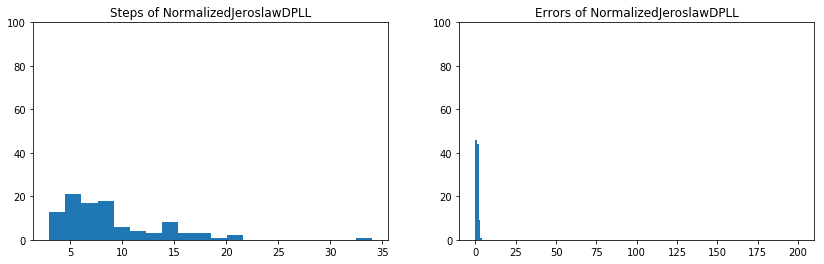

In [19]:
print_all(100, 200, 12)

We have generated 100 formulas
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.89; stdev step: 4.57; avg error: 0.08; stdev error: 0.27


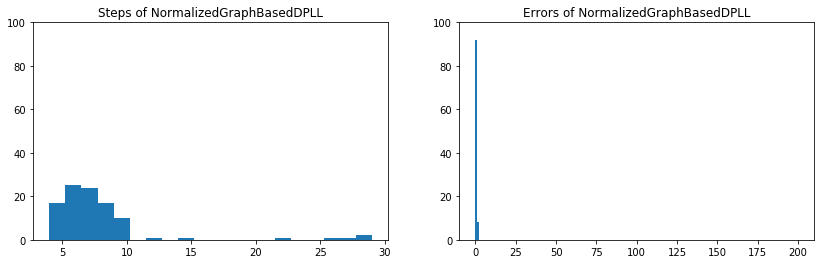

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.90; stdev step: 7.81; avg error: 1.13; stdev error: 0.88


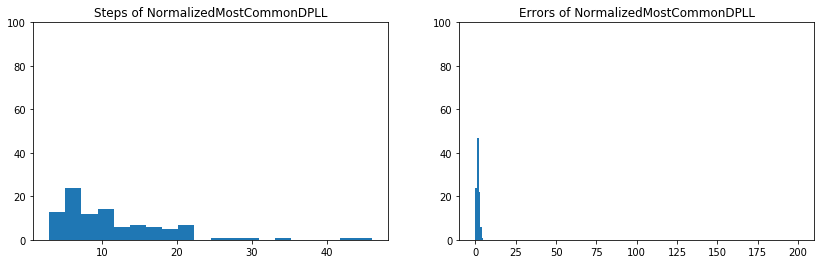

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.61; stdev step: 6.12; avg error: 0.80; stdev error: 0.73


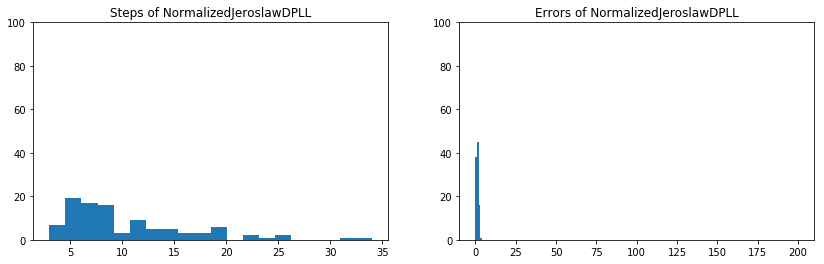

In [20]:
print_all(100, 200, 14)

We have generated 100 formulas
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.13; stdev step: 5.28; avg error: 0.10; stdev error: 0.30


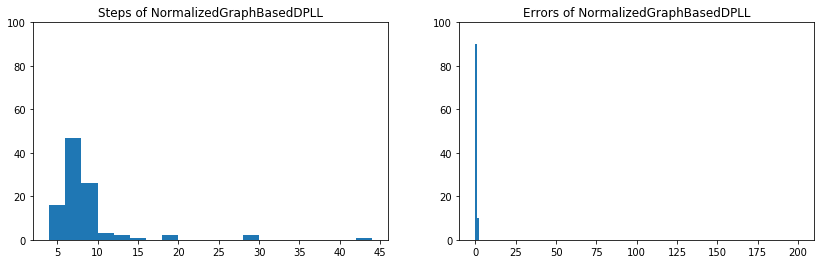

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 15.44; stdev step: 10.14; avg error: 1.33; stdev error: 0.88


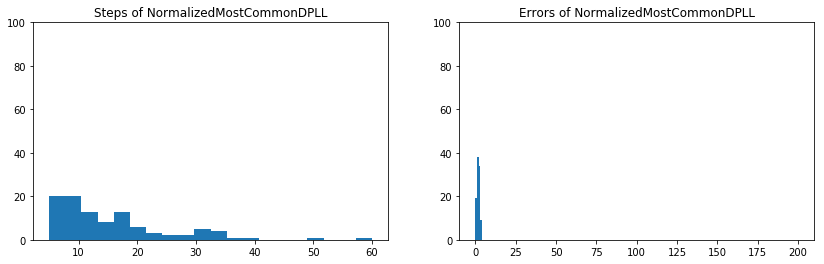

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.89; stdev step: 6.72; avg error: 0.89; stdev error: 0.66


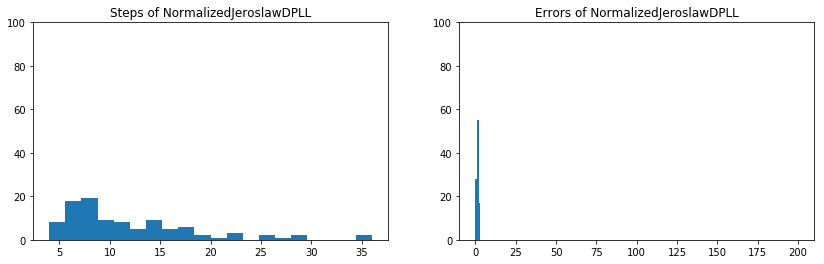

In [21]:
print_all(100, 200, 16)

We have generated 10 formulas
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.00; stdev step: 7.38; avg error: 0.20; stdev error: 0.40


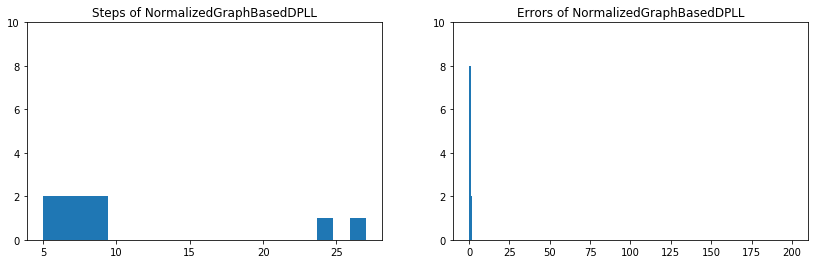

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 19.10; stdev step: 8.88; avg error: 1.60; stdev error: 0.92


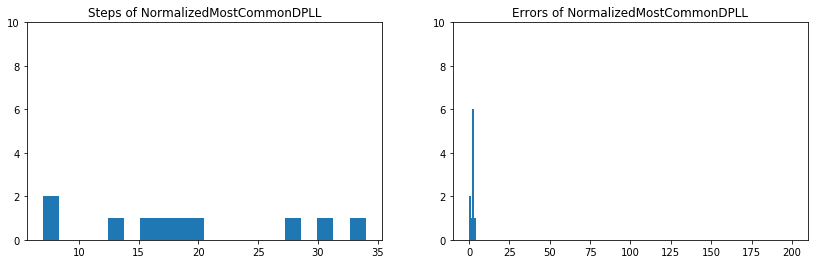

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 17.80; stdev step: 10.84; avg error: 0.90; stdev error: 0.70


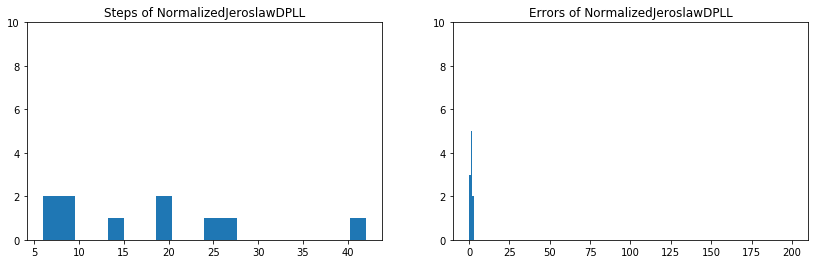

In [23]:
print_all(10, 200, 20)

We have generated 10 formulas
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 14.30; stdev step: 10.81; avg error: 0.10; stdev error: 0.30


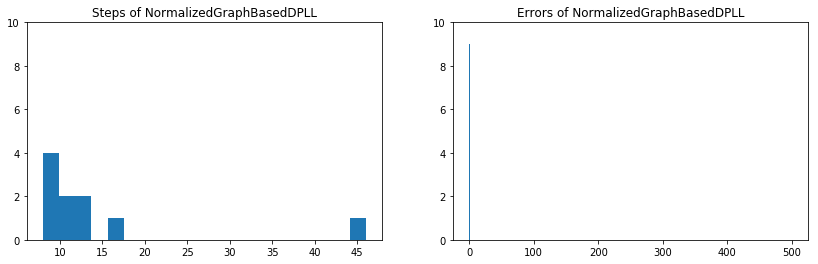

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 28.70; stdev step: 21.03; avg error: 1.40; stdev error: 1.02


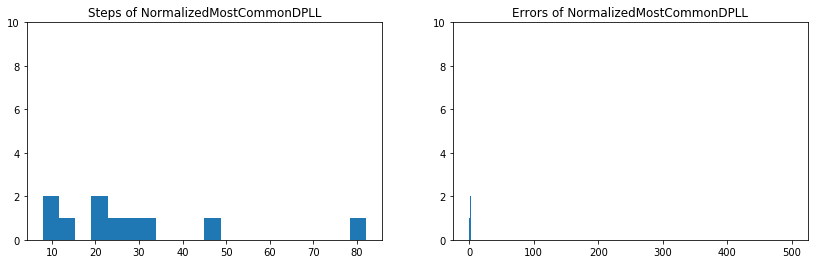

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 20.10; stdev step: 15.03; avg error: 1.00; stdev error: 1.10


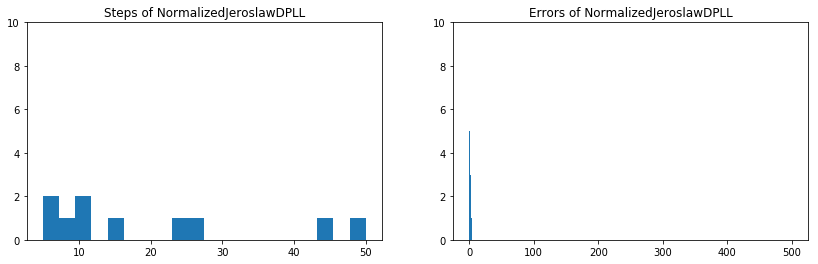

In [24]:
print_all(10, 500, 25, light=True)

We have generated 10 formulas
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 16.20; stdev step: 17.01; avg error: 0.10; stdev error: 0.30


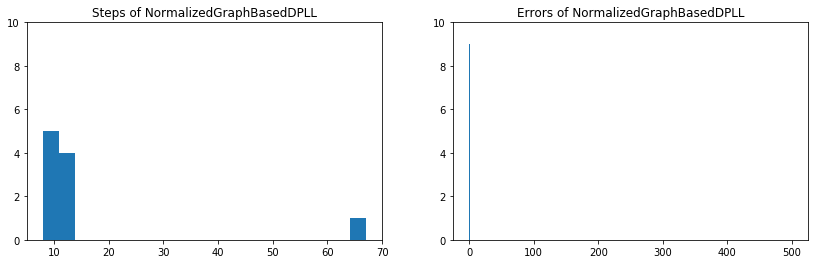

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 47.90; stdev step: 40.97; avg error: 2.00; stdev error: 1.67


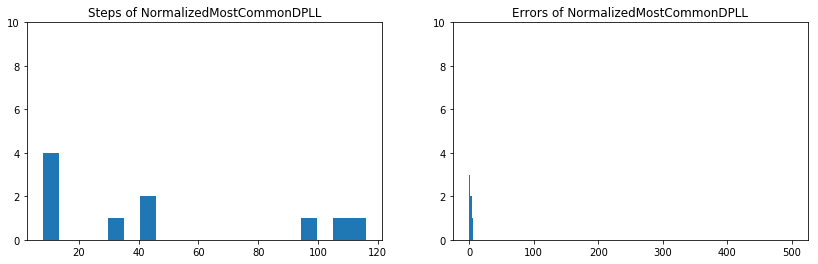

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 29.30; stdev step: 20.95; avg error: 1.60; stdev error: 0.80


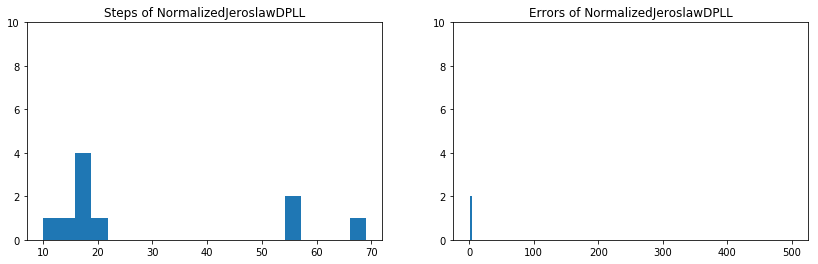

In [25]:
print_all(10, 500, 30, light=True)

We have generated 10 formulas
Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 36.80; stdev step: 68.43; avg error: 0.10; stdev error: 0.30


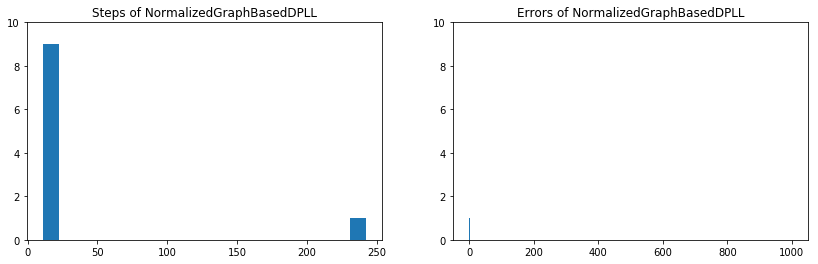

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 215.10; stdev step: 190.49; avg error: 3.10; stdev error: 1.70


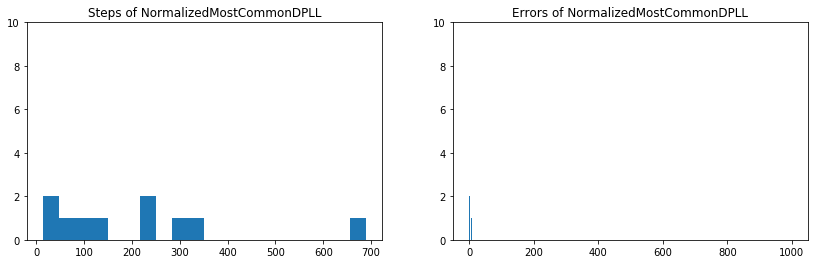

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 84.90; stdev step: 53.66; avg error: 1.90; stdev error: 0.94


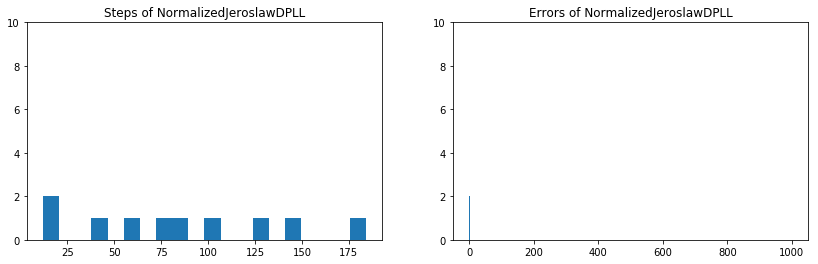

In [26]:
print_all(10, 1000, 40, light=True)

We have generated 10 formulas
Within 1000 steps solved 9 problems out of 10
#Sats: 9; avg step: 61.33; stdev step: 83.77; avg error: 0.22; stdev error: 0.42


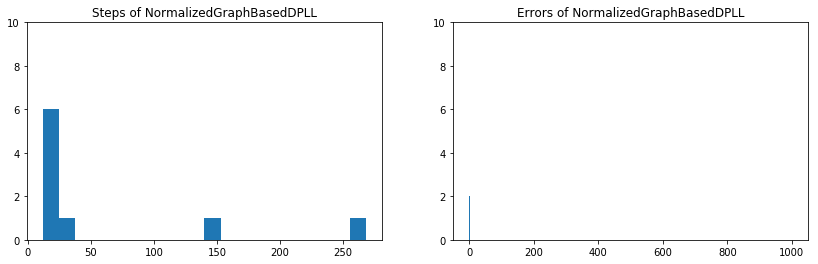

Within 1000 steps solved 8 problems out of 10
#Sats: 8; avg step: 93.25; stdev step: 92.82; avg error: 1.88; stdev error: 1.27


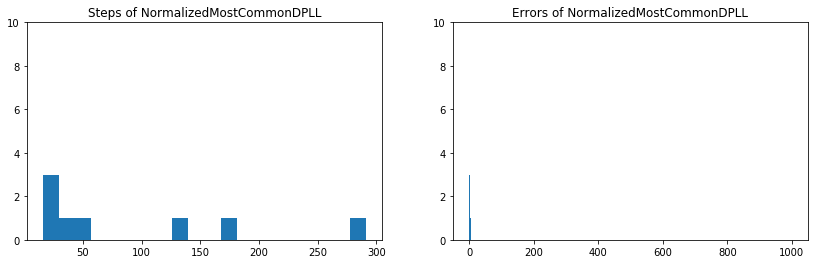

Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 121.10; stdev step: 103.48; avg error: 2.00; stdev error: 1.48


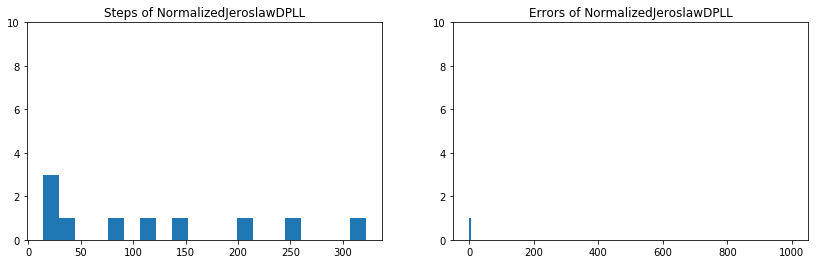

In [27]:
print_all(10, 1000, 50, light=True)

We have generated 10 formulas
Within 1000 steps solved 8 problems out of 10
#Sats: 8; avg step: 64.62; stdev step: 98.81; avg error: 0.25; stdev error: 0.43


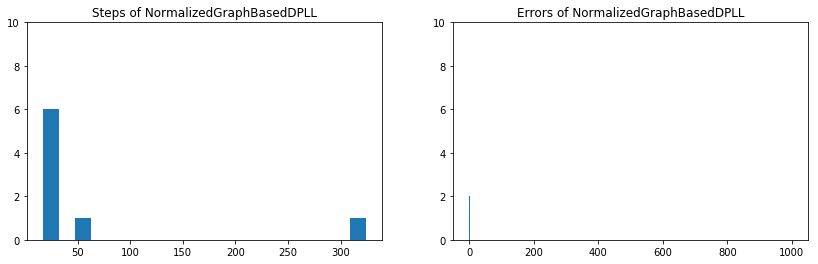

Within 1000 steps solved 3 problems out of 10
#Sats: 3; avg step: 419.00; stdev step: 277.91; avg error: 4.33; stdev error: 0.94


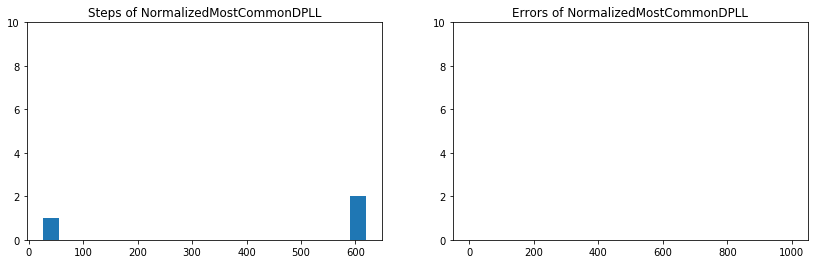

Within 1000 steps solved 9 problems out of 10
#Sats: 9; avg step: 406.89; stdev step: 341.71; avg error: 2.22; stdev error: 1.23


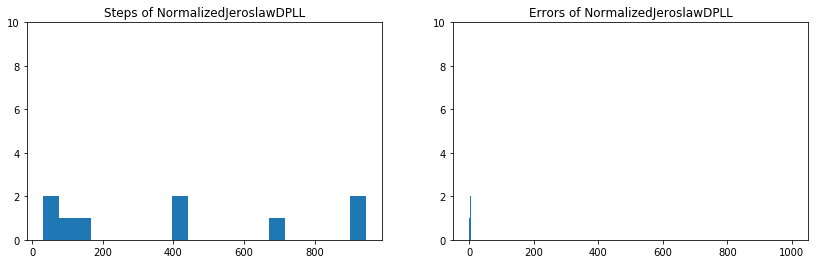

In [28]:
print_all(10, 1000, 70, light=True)

In [29]:
print_all(10, 1000, 90, light=True)

We have generated 10 formulas


KeyboardInterrupt: 